# Inference of the Huge Transformer Models with NVIDIA FasterTransformer  <br/> and TRITON Inference server <img src="http://developer.download.nvidia.com//notebooks/dlsw-notebooks/gpt-j_and_t5_inference/nvidia_logo.png" style="width: 90px; float: right;">

# Prerequisites

To reproduce all further steps that would be easier to run everything into Docker container with pre-baked triton and triton's fastertransformer_backend <br/> Basic Dockerfile that may be used for image and container creation is placed here: <br/> https://github.com/triton-inference-server/fastertransformer_backend/tree/t5_gptj_blog/docker/Dockerfile 

1. Create the directory where you will run all experiments<br/>
<code>mkdir nv_ft_inference && cd nv_ft_inference</code><br/>
2. Clone fastertransformer_backend repo from GitHub<br/>
<code>git clone https://github.com/triton-inference-server/fastertransformer_backend.git</code> <br/>
<code>cd fastertransformer_backend && git checkout -b t5_gptj_blog remotes/origin/dev/t5_gptj_blog</code>
2. Build docker image using this file<br/>
 <code>docker build --rm  --build-arg TRITON_VERSION=22.03 -t triton_with_ft:22.03 -f docker/Dockerfile .</code>
3. Run docker container <br/>
 <code>cd ../</code><br/>
 <code>docker run -it --rm --gpus=all --shm-size=4G  -v $(pwd):/ft_workspace -p 8888:8888 triton_with_ft:22.03 bash</code>
4. Into the container go to the workspace folder <br/>
 <code>cd /ft_workspace</code>
5. All further steps need to be run into the docker container
6. Jupyter Lab is also needed in this container to work with the notebook provided <br/>
 <code>pip install jupyterlab && jupyter lab --ip 0.0.0.0 --allow-root</code>
7. In jupyter lab open notebook `./fastertransformer_backend/notebooks/GPT-J_and_T5_inference.ipynb`

# Overall pipeline

The overall pipeline of all preparation steps for inference looks like this: 

<center></center>

Let's briefly discuss the steps that we have to do:
* <b>Steps 1, 2:</b> Build docker container with TRITON inference server and FasterTransformer <b> backend</b>. We will use TRITON inference server as the main serving tool and also a custom backend for it `fastertransformer backend`. We've done this step in the `Prerequisites` section. `fastertransformer backend` for TRITON contains examples of TRITON configs for GPT, GPTJ, T5, and other models. That will be used by us. 
* <b>Steps 3, 4:</b> Build FasterTransformer library. This is the library that contains a lot of useful tools for inference preparation as well as bindings for multiple languages and examples how to do inference in C++ and Python.
* <b>Step 5-6:</b> Download weights of the pretrained models (T5-3B and GPT-J) and prepare them for the inference with FT by converting into binary format and splitting them onto multiple partitions for parallelism and accelerated inference. Code from `FasterTransformer` library will be used on this step.
* <b>Step 7:</b> Using code from `FasterTransformer` library we will find optimal low-level kernels for our NN.
* <b>Step 8:</b> Start the TRITON server and run client code to send request to the accelerated models. <br/>
<br/>
Overall three artifacts are needed for TRITON server with fastertransformer to run the inference of the Huge transformer model:
1. <i>Mandatory.</i> TRITON's standard config `config.pbtxt` that describes our model. Its inputs and outputs and additional parameters like a number of tensor_parallelism and pipeline_parallelism partitions. This config should come from Step 1.
2. <i>Mandatory.</i> Weights of the model prepared for the FT backend. We prepare these weights using code after steps 3,4.
3. <i>Optional.</i> Config `gemm_config.in` with numbers of optimal low-level CUDA kernels for our current model and hardware. If this config won't be provided the default inference kernels will be used. This config will be generated by us using code after steps 3,4.


# 1. Download code of the fastertransformer_backend for TRITON Inference Server

Fastertransformer_backend for TRITON Inference Server is already installed into TRITON in our container. So we do not have to do this manually.<br/>
And we download and attached at `/ft_workspace/fastertransformer_backend` directory fasterttransformer_backend code from GitHub to use TRITON's configs for T5 and GPT-J prepared by NVIDIA. <br/>
They are placed at <code>fastertransformer_backend/all_models</code>

Let's create the main folder `triton-model-store` onto our server that will be passed into triton as the main repository/folder with our models and configs for them:

In [1]:
%cd /ft_workspace

/ft_workspace


In [ ]:
!mkdir triton-model-store

# 2. Download the code of the FasterTransformer library from GitHub

FasterTransformer library was pre-built and placed into our container as-is. So we do not have to build it manually.<br/>
But we download FasterTransformer code from Github to use additional scripts in it that allows to convert pre-trained files of the GPT-J or T5 into FT binary format that will be used at the inference time.

In [2]:
#!git clone https://github.com/NVIDIA/FasterTransformer.git
%cd FasterTransformer
!git checkout 6b3fd4392831f972d48127e881a048567dd92811
%cd ../

/ft_workspace/FasterTransformer
HEAD is now at 6b3fd43 Update gpt_guide.md
/ft_workspace


We have to build the library to have the ability to run C++ based code for kernel autotuning later

In [3]:
%cd FasterTransformer/

/ft_workspace/FasterTransformer


In [4]:
!mkdir -p build
%cd build 

/ft_workspace/FasterTransformer/build


In [5]:
!git submodule init && git submodule update
!cmake -DSM=xx -DCMAKE_BUILD_TYPE=Release -DBUILD_PYT=ON -DBUILD_MULTI_GPU=ON ..
!make -j32

-- Found CUDA: /usr/local/cuda (found suitable version "11.8", minimum required is "10.2") 
CUDA_VERSION 11 is greater or equal than 11, enable -DENABLE_BF16 flag
-- Add DBUILD_MULTI_GPU, requires MPI and NCCL
-- Determining NCCL version from /usr/include/nccl.h...
-- Found NCCL (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libnccl.so.2.15.5)
-- Assign GPU architecture (sm=70,75,80,86)
-- COMMON_HEADER_DIRS: /ft_workspace/FasterTransformer;/usr/local/cuda/include
-- Found CUDA: /usr/local/cuda (found version "11.8") 
-- Caffe2: CUDA detected: 11.8
-- Caffe2: CUDA nvcc is: /usr/local/cuda/bin/nvcc
-- Caffe2: CUDA toolkit directory: /usr/local/cuda
-- Caffe2: Header version is: 11.8
-- Found cuDNN: v8.7.0  (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libcudnn.so)
-- /usr/local/cuda/lib64/libnvrtc.so shorthash is 672ee683
-- Added CUDA NVCC flags for: -gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gen

In [26]:
%cd ../../

/


So now we have downloaded and prepared code of the `FasterTransformer` library that helps us to prepare pretrained models for the inference and also we prepared code of the `fastertransformer_backend` that contains TRITON-aware json configs for our GPT-J and T5 models. So we are ready to download pretrained weights of our models and run the inference.

### 3.1 Overview

Let's have a look at the TRITON's config for the GPT-J model `./fastertransformer_backend/all_models/t5`:

In [4]:
import logging, sys
logging.disable(sys.maxsize)

In [27]:
%cd /ft_workspace
!ls ./fastertransformer_backend/all_models/gpt

/ft_workspace
ensemble  fastertransformer  postprocessing  preprocessing


At this time we have only one `fastertransformer` subfolder for our `T5` model. That means that we have only NN inference stage on the Server side and we do not have a full pipeline with preprocessing and postprocessing (that we had in GPT-J). All pre and post processing stages need to e done on the Client side. TRITON allows you to configure your inference flexibly so it's possible to build full pipeline on the server side too, but we want to practice with other configs. So we will do a conversion from text into tokens in Python using Huggingface on the Client side, after that we will send request to the server and after getting a response we convert generated tokens into the text.<br/> 
Overall client-server inference scheme looks like this:

<center>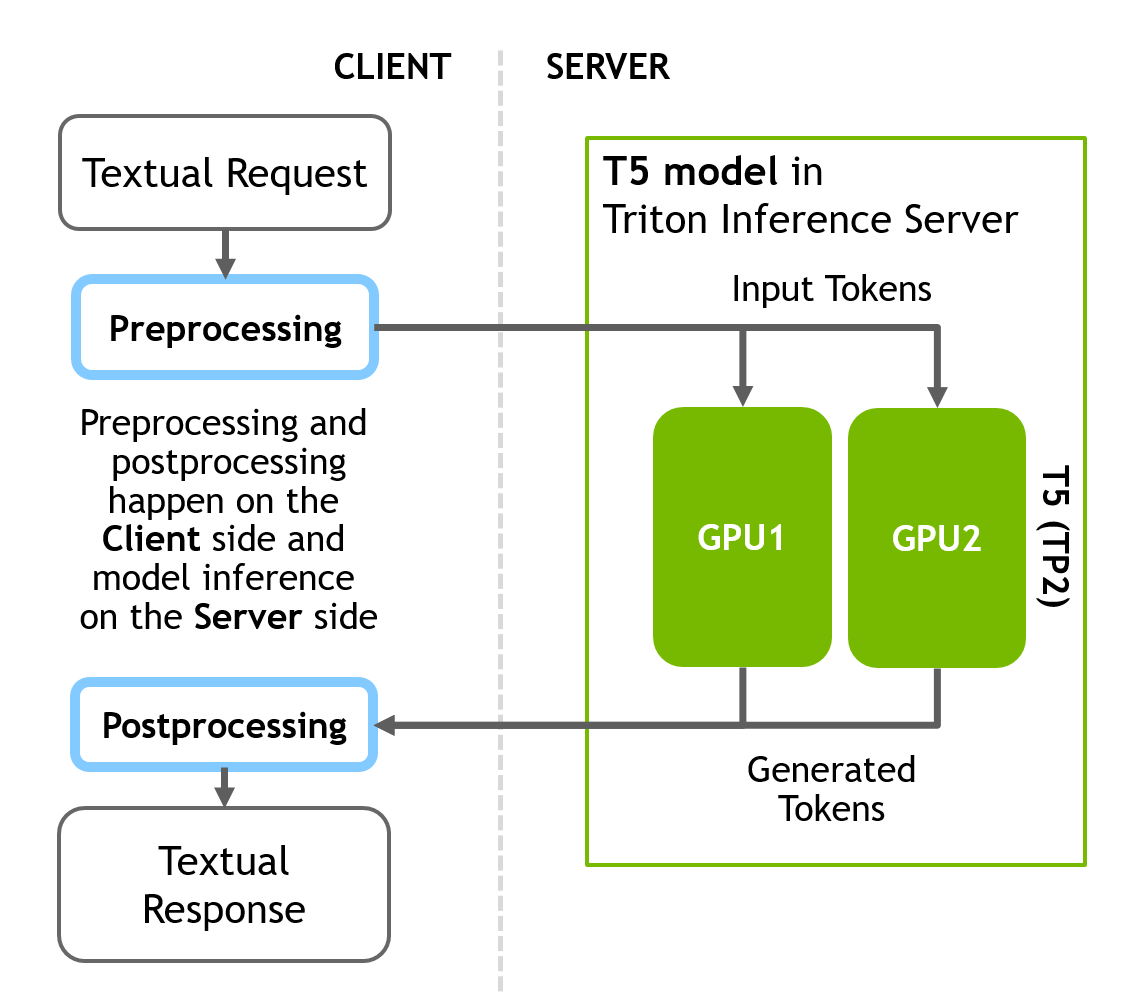</center>

### 3.2 Preprocess Model for using Triton-Inference Server (to FASTERTRANSFORMER format)

In [8]:
!pip3 install jaxlib==0.3.10 jax==0.3.13 transformers==4.19.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 MB 6.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.0/951.0 kB 7.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 7.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.0 MB/s eta 0:00:0000:0100:01
  Created wheel for jax: filename=jax-0.3.13-py3-none-any.whl size=1099563 sha256=cc3899871b8322e114b85ed8711729cb82f46b7ee0a5fa2a52920c4803715f45
  Stored in directory: /root/.cache/pip/wheels/8f/99/50/d261121235df31e7aabc66282980282a0a70c1048cf5b360f8
Successfully built jax
  Attempting uninstall: tokenizers
    Found existing installation: tokeni

1. `-i`: transformers 모델 위치
2. `-o`: fastertransformers 저장 위치
3. `-i_g`: 사용 예정이 GPU 수
infer_gpu_num
4. `-weight_data_type`: weights 타입 `fp32` or `fp16`

In [1]:
cd /ft_workspace

/ft_workspace


In [2]:
!python3 FasterTransformer/examples/pytorch/gpt/utils/huggingface_gpt_convert.py \
        -i ./models/dialog_gpt_v2 \
        -o ./models/dialogpt2_not_deep_v2/ \
        -i_g 2 \
        -weight_data_type fp16


=============== Argument ===============
saved_dir: ./models/dialogpt2_not_deep_v2/
in_file: ./models/dialog_gpt_v2
trained_gpu_num: 1
infer_gpu_num: 2
processes: 4
weight_data_type: fp16
Some weights of the model checkpoint at ./models/dialog_gpt_v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 3.2.4 Prepare the TRITON's config of the T5 model

`triton-model-store` 폴더로 기본 config copy

In [2]:
!cp -r ./fastertransformer_backend/all_models/gpt/ triton-model-store_hoo/

config path: `triton-model-store/t5/fastertransformer/config.pbtxt`
<br>수정해야 할 parameter<br>
<code>
parameters {
  key: "tensor_para_size"
  value: {
    string_value: "2" # num gpus
  }
}
</code> <br/>
<code>
parameters {
  key: "model_checkpoint_path"
  value: {
    string_value: "./models/t5-3b/2-gpu/" # model weight path
  }
}
</code> 

### 3.4 Start TRITON inference server with TRITON backend and T5

In [16]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.4 MB/s eta 0:00:0000:0100:06
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cu111
    Uninstalling torch-1.9.1+cu111:
      Successfully uninstalled torch-1.9.1+cu111


In [1]:
%cd /ft_workspace/
import os
os.system("CUDA_VISIBLE_DEVICES=0,1 /opt/tritonserver/bin/tritonserver --log-warning false --model-repository=./triton-model-store_hoo/gpt/ &")

/ft_workspace


0

I1220 03:05:29.371129 153963 pinned_memory_manager.cc:240] Pinned memory pool is created at '0x7fa7ba000000' with size 268435456
I1220 03:05:29.372062 153963 cuda_memory_manager.cc:105] CUDA memory pool is created on device 0 with size 67108864
I1220 03:05:29.372076 153963 cuda_memory_manager.cc:105] CUDA memory pool is created on device 1 with size 67108864
I1220 03:05:29.568212 153963 model_lifecycle.cc:459] loading: fastertransformer:1
I1220 03:05:29.568280 153963 model_lifecycle.cc:459] loading: postprocessing:1
I1220 03:05:29.568324 153963 model_lifecycle.cc:459] loading: preprocessing:1
I1220 03:05:29.813333 153963 libfastertransformer.cc:1226] TRITONBACKEND_Initialize: fastertransformer
I1220 03:05:29.813382 153963 libfastertransformer.cc:1236] Triton TRITONBACKEND API version: 1.10
I1220 03:05:29.813394 153963 libfastertransformer.cc:1242] 'fastertransformer' TRITONBACKEND API version: 1.10
I1220 03:05:29.815963 153963 libfastertransformer.cc:1274] TRITONBACKEND_ModelInitialize

[FT][WARNING] Custom All Reduce only supports 8 Ranks currently. Using NCCL as Comm.
after allocation, free 23.21 GB total 23.69 GB
after allocation, free 23.22 GB total 23.69 GB
[WARNING] gemm_config.in is not found; using default GEMM algo


I1220 03:05:32.544672 153963 libfastertransformer.cc:321] After Loading Model:


after allocation, free 22.24 GB total 23.69 GB
[WARNING] gemm_config.in is not found; using default GEMM algo
after allocation, free 22.25 GB total 23.69 GB


I1220 03:05:33.118538 153963 libfastertransformer.cc:537] Model instance is created on GPU NVIDIA RTX A5000
I1220 03:05:33.118837 153963 model_lifecycle.cc:694] successfully loaded 'fastertransformer' version 1
I1220 03:05:38.547458 153963 python_be.cc:1856] TRITONBACKEND_ModelInstanceInitialize: postprocessing_0 (CPU device 0)
I1220 03:05:39.731354 153963 python_be.cc:1856] TRITONBACKEND_ModelInstanceInitialize: preprocessing_0 (CPU device 0)
I1220 03:05:39.731594 153963 model_lifecycle.cc:694] successfully loaded 'postprocessing' version 1
I1220 03:05:41.016253 153963 model_lifecycle.cc:694] successfully loaded 'preprocessing' version 1
I1220 03:05:41.016790 153963 model_lifecycle.cc:459] loading: ensemble:1
I1220 03:05:41.017093 153963 model_lifecycle.cc:694] successfully loaded 'ensemble' version 1
I1220 03:05:41.017172 153963 server.cc:563] 
+------------------+------+
| Repository Agent | Path |
+------------------+------+
+------------------+------+

I1220 03:05:41.017244 153963

### 3.5 Run the Client script

In [4]:
!nvidia-smi

Fri Dec 16 14:47:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   49C    P8    21W / 230W |   1482MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:04:00.0 Off |                  Off |
| 30%   

In [10]:
import numpy as np
import tritonclient.http as httpclient

from tritonclient.utils import np_to_triton_dtype

URL = "localhost:8000"
MODEl_GPT_FASTERTRANSFORMER = "ensemble" 

OUTPUT_LEN = 128
BATCH_SIZE = 1
BEAM_WIDTH = 2
TOP_K = 5
TOP_P = 0.0

start_id = 50256
end_id = 50256

In [11]:
client = httpclient.InferenceServerClient("localhost:8000",
                                           concurrency=1,
                                           verbose=False)

In [12]:
# Inference hyperparameters
def prepare_tensor(name, input):
    tensor = httpclient.InferInput(
        name, input.shape, np_to_triton_dtype(input.dtype))
    tensor.set_data_from_numpy(input)
    return tensor

# explanation
def prepare_inputs(input0):
    bad_words_list = np.array([[""]], dtype=object)
    stop_words_list = np.array([[""]], dtype=object)
    input0_data = np.array(input0).astype(object)
    output0_len = np.ones_like(input0).astype(np.uint32) * OUTPUT_LEN
    runtime_top_k = (TOP_K * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    runtime_top_p = TOP_P * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    beam_search_diversity_rate = 0.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    temperature = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    len_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    repetition_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    random_seed = 0 * np.ones([input0_data.shape[0], 1]).astype(np.int32)
    is_return_log_probs = True * np.ones([input0_data.shape[0], 1]).astype(bool)
    beam_width = (BEAM_WIDTH * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    start_ids = start_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)
    end_ids = end_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)

    inputs = [
        prepare_tensor("INPUT_0", input0_data),
        prepare_tensor("INPUT_1", output0_len),
        prepare_tensor("INPUT_2", bad_words_list),
        prepare_tensor("INPUT_3", stop_words_list),
        prepare_tensor("runtime_top_k", runtime_top_k),
        prepare_tensor("runtime_top_p", runtime_top_p),
        prepare_tensor("beam_search_diversity_rate", beam_search_diversity_rate),
        prepare_tensor("temperature", temperature),
        prepare_tensor("len_penalty", len_penalty),
        prepare_tensor("repetition_penalty", repetition_penalty),
        prepare_tensor("random_seed", random_seed),
        prepare_tensor("is_return_log_probs", is_return_log_probs),
        prepare_tensor("beam_width", beam_width),
        prepare_tensor("start_id", start_ids),
        prepare_tensor("end_id", end_ids),
    ]
    return inputs

In [44]:
print("Write any input prompt for the model and press ENTER:")
input_user = input()
input0 = [[input_user],]
inputs = prepare_inputs(input0)

Write any input prompt for the model and press ENTER:


 my children often called superhero.


In [45]:
result = client.infer(MODEl_GPT_FASTERTRANSFORMER, inputs)
output0 = result.as_numpy("OUTPUT_0")
print(output0[1])

I1220 03:27:55.330350 153963 libfastertransformer.cc:834] Start to forward
I1220 03:27:55.330364 153963 libfastertransformer.cc:834] Start to forward


b'my children often called superhero. superman is better than superman . who is your favorite superhero ?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

I1220 03:27:55.732075 153963 libfastertransformer.cc:836] Stop to forward
I1220 03:27:55.732107 153963 libfastertransformer.cc:836] Stop to forward


In [5]:
from datasets import load_dataset

data = load_dataset("conv_ai_2",split="train")

Found cached dataset conv_ai_2 (/root/.cache/huggingface/datasets/conv_ai_2/conv_ai_2/1.0.0/11d600ddce66bb9d07ca50d1b55b488145ef0d5d0206168c32f1043677875865)


In [6]:
per = ""
for idx, persona in enumerate(data[0]["bot_profile"]):
    per += f"<p{idx}>" + ''.join(persona)
    
per += "<user>"

In [7]:
print('-----------------------------------prepared persona------------------------------ : ')
print(per)

-----------------------------------prepared persona------------------------------ : 
<p0>i have amazing children and grandchildren.<p1>i can sew my own clothes.<p2>i had cancer but its gone now.<p3>i am retired and living the great life.<p4>i do not have a smartphone.<user>


In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
%cd /ft_workspace/models
model = AutoModelForCausalLM.from_pretrained("./dialog_gpt").to('cuda:0')

/ft_workspace/models


In [9]:
import time
infer_time = 0
turn = 0

for i in range(3):
    next_per = per
    context = next_per +  "<user>"
    input_user = input('user : ')
    input_user = next_per + input_user + "<bot>"
    start = time.time()
    
    input_ids = tokenizer.encode(context, return_tensors='pt')
    input_ids = input_ids.to('cuda:0')
    output = model.generate(input_ids, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)
    context2 = tokenizer.decode(output[0], skip_special_tokens=True)
    end = time.time()
    infer_time += end - start
  
    
    input0 = [[input_user],]
    inputs = prepare_inputs(input0)
    
    result = client.infer(MODEl_GPT_FASTERTRANSFORMER, inputs)
    output0 = result.as_numpy("OUTPUT_0")
    output0[0] = str(output0[0], 'utf-8').replace('<|endoftext|>', "")
    
    print('bot :', output0[0][len(input_user):].split('<')[0])
    
    next_per = input_user + output0[0][len(input_user):].split('<')[0] + "<user>"

print(f"Average inference time: {infer_time/turn}/it")


user :  hi how are you?


I1220 03:06:40.753971 153963 libfastertransformer.cc:834] Start to forward
I1220 03:06:40.753998 153963 libfastertransformer.cc:834] Start to forward
I1220 03:06:40.811223 153963 libfastertransformer.cc:836] Stop to forward
I1220 03:06:40.811240 153963 libfastertransformer.cc:836] Stop to forward


bot : 


user :  done what is your number?


I1220 03:06:53.851564 153963 libfastertransformer.cc:834] Start to forward
I1220 03:06:53.851620 153963 libfastertransformer.cc:834] Start to forward
I1220 03:06:53.873876 153963 libfastertransformer.cc:836] Stop to forward
I1220 03:06:53.873893 153963 libfastertransformer.cc:836] Stop to forward


bot : 


user :  stop


I1220 03:07:01.602765 153963 libfastertransformer.cc:834] Start to forward
I1220 03:07:01.602779 153963 libfastertransformer.cc:834] Start to forward
I1220 03:07:01.611438 153963 libfastertransformer.cc:836] Stop to forward
I1220 03:07:01.611453 153963 libfastertransformer.cc:836] Stop to forward


bot : 


ZeroDivisionError: float division by zero